In [1]:
# All configs

data_path = "../spunup_tsrt_r50/"

output_path = "../spunup_tsrt_r50/report"

# path to mjolnir from execution directory, used if ran in another folder, e.g. with 'muninn' script
mjolnir_path = "./"

FIGSIZE_x = 10
FIGSIZE_y = 7

VIDEO_x = 1280
VIDEO_DISPLAY_x = 800
dpi = 296

In [2]:
# path to mjolnir code
import sys
sys.path.append(mjolnir_path) 

import pathlib
import re

import h5py
import imageio
import IPython.display as disp

import math

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps
from matplotlib.backends.backend_agg import FigureCanvasAgg
# from pygifsicle import optimize

import hamarr as ham
import mjolnir_plot_helper as mph
from file_helpers import get_path_matching_regex, get_path_matching_regex_with_groups

In [3]:
exp_path = pathlib.Path(data_path) 
output_dir = pathlib.Path(output_path)

FIGSIZE = (FIGSIZE_x, FIGSIZE_y)



In [4]:
# get planet file

planet_files = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_planet_(.+).h5"
)

if len(planet_files) == 1:
    planet_name = planet_files[0]['groups'][0] 
    planet_file = planet_files[0]['path']
    
    print(f"Found planet name '{planet_name}'")
else:
    raise Exception("Error looking for single planet files. Found:", planet_files)

Found planet name 'Wasp43b'


In [5]:
# get grid file

grid_files = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_grid_(.+).h5"
)

if len(grid_files) == 1:
    planet_g_name = grid_files[0]['groups'][0] 
    grid_file = grid_files[0]['path']
    
    print(f"Found grid file '{grid_file}'")
else:
    raise Exception("Error looking for single grid files. Found:", grid_files)

Found grid file '../spunup_tsrt_r50/esp_output_grid_Wasp43b.h5'


In [6]:
print()
print("Planet Parameters")
print("=================")
print()

with h5py.File(planet_file, 'r') as p:
    for k in p.keys():
        print(f"{k:<30}: {str(p[k][...]):>15}")
    
    has_TSRT = "two_streams_radiative_transfer" in p
    has_RT = "radiative_transfer" in p
    
    print()
    print("Modules")
    print("-------")
    print()
    print(f"Radiative transfer: {has_RT}")
    print(f"Two stream radiative transfer: {has_TSRT}")


Planet Parameters

A                             :     [72427000.]
Cp                            :        [13000.]
DeepModel                     :            [1.]
DiffSponge                    :            [0.]
Diffc                         :         [0.015]
DivDampP                      :            [1.]
Gravit                        :           [47.]
HyDiff                        :            [1.]
NonHydro                      :            [1.]
Omega                         :      [9.09e-05]
P_Ref                         :     [10000000.]
RayleighSponge                :            [1.]
RayleighSpongeT               :            [0.]
Rd                            :         [3714.]
Ruv_sponge                    :        [0.0001]
Rw_sponge                     :        [0.0001]
Tint                          :          [100.]
Tmean                         :         [1800.]
Top_altitude                  :      [1400000.]
Tstar                         :         [4300.]
alf_compute_periodic

In [7]:
print()
print("Grid Parameters")
print("===============")
print()

with h5py.File(grid_file, 'r') as g:
    # print(g.keys())
              
    #for k in g.keys():
    #    print(f"{k:<30}: {str(g[k][...]):>15}")
    print(f"{'nv':<30}: {str(g['nv'][...]):>15}" )
    print(f"{'point_num':<30}: {str(g['point_num'][...]):>15}" )


Grid Parameters

nv                            :           [40.]
point_num                     :         [2562.]


In [8]:
# get count of output files
outputs = get_path_matching_regex_with_groups(
    exp_path, f"esp_output_{planet_name}_(\d+).h5"
)

# sort'em
d = {}

for o in outputs:
    p = o["path"]
    (idx_chr,) = o["groups"]
    idx = int(idx_chr)
    # print(f"{idx} - {p}")
    d[idx] = p

sorted_files = sorted(d.items())


first_idx = sorted_files[0][0]
last_idx = sorted_files[-2][0]
#last_idx = 20

print()
print("Output files")
print("============")
print()

print(f"First index: {first_idx}")
print(f"Last index: {last_idx}")






Output files

First index: 0
Last index: 9


In [9]:
class args:
    pass


file_idx = 1

args.pview = ["fuptot"]
args.file = [str(exp_path)]
args.simulation_ID = ["auto"]
args.initial_file = [file_idx]
args.last_file = [file_idx]
args.horizontal_lev = [2.5e2]
args.vertical_top = ["default"]
args.split_layer = ["no_split"]
args.coordinate_sys = ["icoh"]
args.lmax_adjust = [0]
args.slice = [0, 180]
args.maketable = False
args.no_pressure_log = False
args.latlonswap = False
args.vcoord = ["pressure"]
args.pgrid_ref = [f"pgrid_{file_idx}_{file_idx}_1.txt"]
args.clevels = [40]

In [10]:
figures_dir = exp_path / "figures"
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)
    
if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=True)

In [11]:
def plot_anim_steps(first_idx, last_idx, args, plot_filename, overwrite_anim=False):
    """Make a movie using args for mjolnir plotting functions, run over all the indexed files"""
    stride = 1
    overwrite = False
    output_anim_file = output_dir / plot_filename

    if output_anim_file.exists() and not overwrite_anim:
        print(
            f"{output_anim_file} already exists, skipping. Set overwrite_anim = True to force"
        )
        return output_anim_file

    fps = 10
    # writer = imageio.get_writer(str(output_image), fps=fps, quality=10)
    writer = imageio.get_writer(str(output_anim_file), fps=fps)

    # for dev, force to use a small number of files
    # last_idx  = 20
    # compute fig size so that it gets rounded to closest multiple of video macro_block_size
    block_size = 16
    fs_x = (math.ceil((FIGSIZE_x*dpi)/float(block_size))*block_size)/dpi
    fs_y = (math.ceil((FIGSIZE_y*dpi)/float(block_size))*block_size)/dpi
    
    fig = plt.Figure(figsize=(fs_x, fs_y), dpi=dpi)
    ax = fig.subplots(1, 1)
    
    #size=(VIDEO_x, int(VIDEO_x/FIGSIZE_x*FIGSIZE_y))

    for i in range(first_idx, last_idx + 1):

        print(f"plotting: {i: 5}/{last_idx}\r", end="")
        args.initial_file = [i]
        args.last_file = [i]
        args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

        fig.clear()
        ax = fig.add_subplot(111)

        pgrid_ref = exp_path / args.pgrid_ref[0]
        if pgrid_ref.exists():
            pass
        else:
            ham.define_Pgrid(
                args.file[0],
                planet_name,
                args.initial_file[0],
                args.last_file[0],
                stride,
                overwrite=overwrite,
            )

        mph.make_plot(args, False, axis=(fig, ax))

        # canvas = fig.canvas
        canvas = FigureCanvasAgg(fig)

        # Option 2: Retrieve a view on the renderer buffer...
        canvas.draw()
        buf = canvas.buffer_rgba()
        # ... convert to a NumPy array ...
        X = np.asarray(buf)
        # ... and pass it to PIL.
        # im = Image.fromarray(X)

        #import pdb; pdb.set_trace()
        writer.append_data(X)

    writer.close()

    # optimize gif output
    #optimize(str(output_image))

    return output_anim_file


def plot_steps(plot_type, first_idx, last_idx, args):
    #fig, ((ax_first, ax_last), (ax_second, ax_mid)) = plt.subplots(
    #    2, 2, figsize=FIGSIZE
    #)
    fig = plt.Figure(figsize=FIGSIZE)
    ((ax_first, ax_last), (ax_second, ax_mid)) = fig.subplots(2,2)

    i = first_idx
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_first))
    ttl = ax_first.get_title()
    ax_first.set_title(ttl + "\n" + "Initial (idx=0)")

    i = last_idx
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_last))
    ttl = ax_last.get_title()
    ax_last.set_title(ttl + "\n" + f"Last (idx={i})")

    i = 1
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_second))
    ttl = ax_second.get_title()
    ax_second.set_title(ttl + "\n" + "First step (idx=1)")

    i = (last_idx - first_idx) // 2
    args.pview = [plot_type]
    args.initial_file = [i]
    args.last_file = [i]
    args.pgrid_ref = [f"pgrid_{i}_{i}_1.txt"]

    mph.make_plot(args, False, axis=(fig, ax_mid))
    ttl = ax_mid.get_title()
    ax_mid.set_title(ttl + "\n" + f"Middle step (idx={i})")
    
    return fig

In [12]:
def plot_anim(plotname, plotfile, first, last, args):
    print(f"plotting {plotname} to {plotfile}")
    args.pview = [plotname]
    # don't show interactive plots when not asked to

    output_image = plot_anim_steps(first_idx, last_idx, args, plotfile)

    #im = Image.open(output_image)
    return disp.Video(output_image,width=VIDEO_DISPLAY_x)

In [13]:
# plots = [
#          ("TP", "TP_anim.gif"),
#          ("Tver", "Tver_anim.gif"),
#          ("Tlonver", "Tver_anim.gif"),
#          ("fuptot", "fuptot_anim.gif"),
#          ("fdowntot", "fdowntot_anim.gif"),
#          ("fnet", "fnet_anim.gif"),
#          ("qheat", "qheat_anim.gif"),
#          ("futprof", "futprof_anim.gif"),
#          ("fdtprof", "fdtprof_anim.gif"),
#          ("fnetprof", "fnetprof_anim.gif"),
#         ]

# for plotname, plotfile in plots:
#     print(f"plotting {plotname} to {plotfile}")
#     args.pview = [plotname]
#     output_image = plot_anim_steps(first_idx, last_idx, args, plotfile)
#     im = Image.open(output_image)
#     disp.Image(output_image, format="gif")

# TP Profile

In [14]:
plot_anim("TP", "TP_anim.mp4", first_idx, last_idx, args)

plotting TP to TP_anim.mp4
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None


Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None
Dataset Pressure has already been loaded into memory
Created file: None


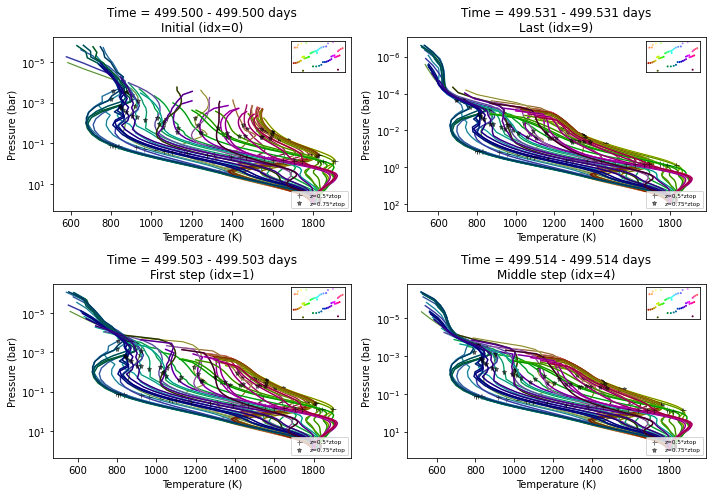

In [15]:
plot_steps("TP", first_idx, last_idx, args)

# Tver

In [16]:
plot_anim("Tver", "Tver_anim.mp4", first_idx, last_idx, args)

plotting Tver to Tver_anim.mp4
../spunup_tsrt_r50/pgrid_0_0_1/regrid_Wasp43b_0.h5 not found, regridding now with default settings...
Regrid data in folder ../spunup_tsrt_r50...

Vertical coordinate = pressure from file ../spunup_tsrt_r50/pgrid_0_0_1.txt
Regridding time = 0...
Writing file ../spunup_tsrt_r50/pgrid_0_0_1/regrid_Wasp43b_0.h5...
Writing file ../spunup_tsrt_r50/regrid_height_Wasp43b_0.h5...


/home/nab/prog/astro/unibe/THOR/mjolnir/hamarr.py:1207: UserWarning: No contour levels were found within the data range.
  c2 = ax.contour(latp * 180 / np.pi, ycoord, zvals, levels=levp, colors='w', linewidths=1)


Created file: None
../spunup_tsrt_r50/pgrid_1_1_1/regrid_Wasp43b_1.h5 not found, regridding now with default settings...
Regrid data in folder ../spunup_tsrt_r50...

Vertical coordinate = pressure from file ../spunup_tsrt_r50/pgrid_1_1_1.txt
Regridding time = 1...
Writing file ../spunup_tsrt_r50/pgrid_1_1_1/regrid_Wasp43b_1.h5...
Writing file ../spunup_tsrt_r50/regrid_height_Wasp43b_1.h5...
Created file: None
../spunup_tsrt_r50/pgrid_2_2_1/regrid_Wasp43b_2.h5 not found, regridding now with default settings...
Regrid data in folder ../spunup_tsrt_r50...

Vertical coordinate = pressure from file ../spunup_tsrt_r50/pgrid_2_2_1.txt
Regridding time = 2...
Writing file ../spunup_tsrt_r50/pgrid_2_2_1/regrid_Wasp43b_2.h5...
Writing file ../spunup_tsrt_r50/regrid_height_Wasp43b_2.h5...
Created file: None
../spunup_tsrt_r50/pgrid_3_3_1/regrid_Wasp43b_3.h5 not found, regridding now with default settings...
Regrid data in folder ../spunup_tsrt_r50...

Vertical coordinate = pressure from file ../sp

Created file: None
Created file: None
Created file: None
Created file: None


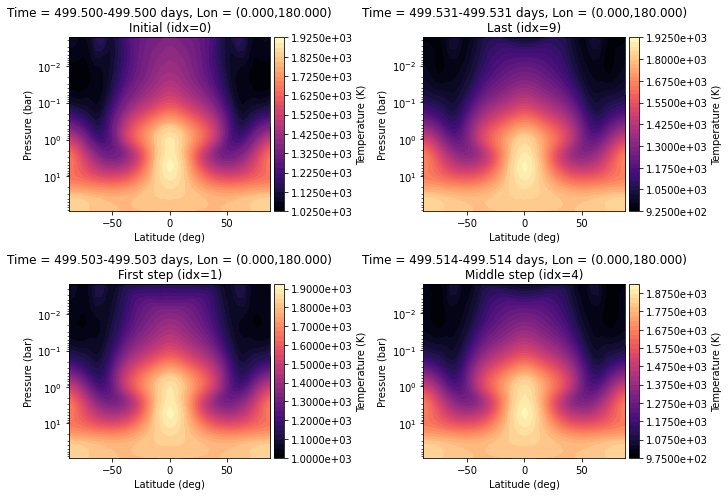

In [17]:
plot_steps("Tver", first_idx, last_idx, args)

# Tlonver

In [18]:
plot_anim("Tlonver", "Tlonver_anim.mp4", first_idx, last_idx, args)

plotting Tlonver to Tlonver_anim.mp4
Created file: None


/home/nab/prog/astro/unibe/THOR/mjolnir/hamarr.py:1446: UserWarning: No contour levels were found within the data range.
  c2 = ax.contour(lonp * 180 / np.pi, ycoord, zvals, levels=levp, colors='w', linewidths=1)


Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None


Created file: None
Created file: None
Created file: None
Created file: None


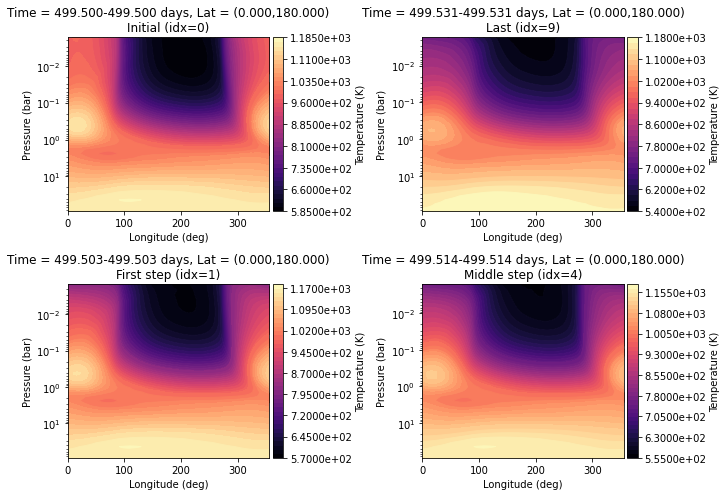

In [19]:
plot_steps("Tlonver", first_idx, last_idx, args)

# Zonal wind profile ulev

In [20]:
plot_anim("uver", "uver_anim.mp4", first_idx, last_idx, args)

plotting uver to uver_anim.mp4
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None


Created file: None
Created file: None
Created file: None
Created file: None


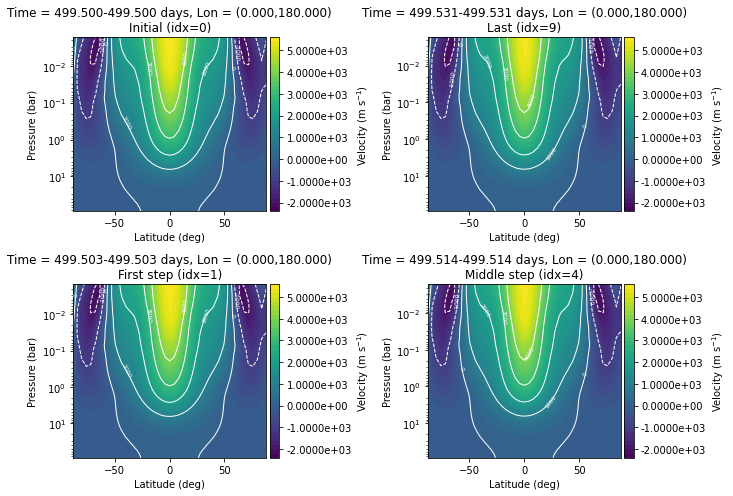

In [21]:
plot_steps("uver", first_idx, last_idx, args)

# Two Stream Radiative transfer

In [22]:
if has_TSRT:
    print("Two Stream Radiative Transfer Enabled")
else:
    print("Two Stream Radiative Transfer Disabled, no plots will appear in this group")

Two Stream Radiative Transfer Enabled


## Qheat

In [23]:
pa = None
if has_TSRT:
    pa = plot_anim("qheat", "qheat_anim.mp4", first_idx, last_idx, args)
    
pa

plotting qheat to qheat_anim.mp4
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None
Created file: None


In [24]:
if has_TSRT:
    plot_steps("qheat", first_idx, last_idx, args)

Created file: None
Created file: None
Created file: None
Created file: None


## Total Upward Flux 

### Profile

In [25]:
pa = None
if has_TSRT:
    pa = plot_anim("futprof", "futprof_anim.mp4", first_idx, last_idx, args)

pa

plotting futprof to futprof_anim.mp4


ValueError: futprof not a valid plot option. Valid options are uver, ulonver, vver, wver, wlonver, wprof, Tver, Tlonver, Tulev, PTver, PTlonver, ulev, PVver, PVlev, TP, RVlev, cons, stream, pause, tracer, PTP, regrid, KE, SR, uprof, cfl, bvprof, TSfluxprof, Tsurf, insol, massf, pause_rg, DGfluxprof, qheat, DGfutprof, DGfdtprof, DGfnetprof, mustar, DGfuptot, DGfdowntot, DGfnet, DGqheat, TSfutprof, TSfdtprof, TSfnetprof, mustar, TSfuptot, TSfdowntot, TSfnet, TSqheat, DGqheatprof, TSqheatprof, qheatprof, phase, all

In [ ]:
if has_TSRT:
    plot_steps("futprof", first_idx, last_idx, args)

### Horizontal

In [ ]:
pa = None
if has_TSRT:
    pa = plot_anim("fuptot", "fuptot_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
if has_TSRT:
    plot_steps("fuptot", first_idx, last_idx, args)

## Total Downward Flux 

### Profile

In [ ]:
pa = None
if has_TSRT:
    pa = plot_anim("fdtprof", "fdtprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
if has_TSRT:
    plot_steps("fdtprof", first_idx, last_idx, args)

### Horizontal

In [ ]:
pa = None
if has_TSRT:
    pa = plot_anim("fdowntot", "fdowntot_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
if has_TSRT:
    plot_steps("fdowntot", first_idx, last_idx, args)

## Total Net Flux 

### Profile

In [ ]:
pa = None 

if has_TSRT:
    pa = plot_anim("fnetprof", "fnetprof_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
if has_TSRT:
    plot_steps("fnetprof", first_idx, last_idx, args)

### Horizontal

In [ ]:
pa = None
if has_TSRT:
    pa = plot_anim("fnet", "fnet_anim.mp4", first_idx, last_idx, args)
    
pa

In [ ]:
if has_TSRT:
    plot_steps("fnet", first_idx, last_idx, args)